In [1]:
'''
# Dependencies:

!pip install pydicom
!conda install plotly
!conda install scikit-image
'''

'\n# Dependencies:\n\n!pip install pydicom\n!conda install plotly\n!conda install scikit-image\n'

In [1]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib import colors
import glob
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.measure import label, regionprops
from keras.utils import to_categorical
from skimage.filters import threshold_triangle
from skimage.morphology import remove_small_holes
from skimage.measure import marching_cubes_lewiner

Using TensorFlow backend.


In [2]:
dicom_path = 'D:/brainData/AIBL/14/MPRAGE_ADNI_confirmed/2008-03-03_14_15_49.0/S63061' #'D:/brainData/real_final_ADNI/002_S_5018\MPRAGE/2013-05-16_12_20_33.0/S189766' # Dicom file floder path
list_test_image = glob.glob(dicom_path + '/*.dcm')


# Print out the first 5 file names to verify. we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(list_test_image))
print ('\n'.join(list_test_image[:5]))

slice_num=len(list_test_image)

Total of 160 DICOM images.
First 5 filenames:
D:/brainData/AIBL/14/MPRAGE_ADNI_confirmed/2008-03-03_14_15_49.0/S63061\AIBL_14_MR_MPRAGE_ADNI_confirmed__br_raw_20090213142644416_1_S63061_I135977.dcm
D:/brainData/AIBL/14/MPRAGE_ADNI_confirmed/2008-03-03_14_15_49.0/S63061\AIBL_14_MR_MPRAGE_ADNI_confirmed__br_raw_20090213142645238_10_S63061_I135977.dcm
D:/brainData/AIBL/14/MPRAGE_ADNI_confirmed/2008-03-03_14_15_49.0/S63061\AIBL_14_MR_MPRAGE_ADNI_confirmed__br_raw_20090213142645530_100_S63061_I135977.dcm
D:/brainData/AIBL/14/MPRAGE_ADNI_confirmed/2008-03-03_14_15_49.0/S63061\AIBL_14_MR_MPRAGE_ADNI_confirmed__br_raw_20090213142645808_101_S63061_I135977.dcm
D:/brainData/AIBL/14/MPRAGE_ADNI_confirmed/2008-03-03_14_15_49.0/S63061\AIBL_14_MR_MPRAGE_ADNI_confirmed__br_raw_20090213142646096_102_S63061_I135977.dcm


In [3]:
# Loop over the image files and store everything into a list.

def load_scan(path):
    slices =  [pydicom.read_file(s) for s in list_test_image if s.endswith(".dcm")] 
    slices.sort(key = lambda x: int(x.InstanceNumber)) #stack
 
    return slices



def get_pixels(scans):
    image = np.stack([s.pixel_array for s in scans]) # default stack axis = 0 // pixel_array function import [y, x], 3D array becomes [z y x]    
    # Convert to int16 (from sometimes int16), 
    # values should always be low enough (<32k)
    image = image.astype(np.int16)


    return image

    

In [4]:
slices = load_scan(dicom_path)
imgs = get_pixels(slices)

In [5]:
def header_deidentification(scans,check=True) :
    
    de_code_list=[0x00080012, # Instance Creation Date
                0x00080013, # Instance Creation Time
                0x00080020, # Study Date
                0x00080021, # Series Date
                0x00080022, # Acquisition Date
                0x00080023, # Image Date, Content Date
                0x00080030, # Study Time
                0x00080031, # Series Time
                0x00080032, # Acquisition Time
                0x00080033, # Image Time, Content Time
                0x00080050, # Accession Number
                0x00080080, # Institution name
                0x00080081, # Institution Address
                0x00080090, # Referring Physician's name
                0x00081010, # Station name
                0x00081040, # Institutional Department name
                0x00081070, # Operator's Name
                0x00100010, # Patient's name
                0x00100020, # Patient's ID
                0x00100030, # Patient's Birth Date
                0x00100040, # Patient's Sex
                0x00101010, # Patient's Age
                0x00204000] # Image Comments
    
    for s in scans :        
        for code in de_code_list :
            # If present, replace with spaces
            try : s[code].value = ''
            except : pass
        
    if check == True : # check option
        print('dicom Instance Number:', scans[0][0x00200013].value,'\n') # s[0x00200013].value: Instance Number        
        for code in de_code_list :
            try : print('DE-IDENTIFIED : ',s[code])
            except : pass      
            

In [6]:
header_deidentification(slices) #check header de-identification

dicom Instance Number: 1 

DE-IDENTIFIED :  (0008, 0013) Instance Creation Time              TM: ''
DE-IDENTIFIED :  (0008, 0020) Study Date                          DA: ''
DE-IDENTIFIED :  (0008, 0021) Series Date                         DA: ''
DE-IDENTIFIED :  (0008, 0022) Acquisition Date                    DA: ''
DE-IDENTIFIED :  (0008, 0023) Content Date                        DA: ''
DE-IDENTIFIED :  (0008, 0030) Study Time                          TM: ''
DE-IDENTIFIED :  (0008, 0031) Series Time                         TM: ''
DE-IDENTIFIED :  (0008, 0032) Acquisition Time                    TM: ''
DE-IDENTIFIED :  (0008, 0033) Content Time                        TM: ''
DE-IDENTIFIED :  (0008, 0080) Institution Name                    LO: ''
DE-IDENTIFIED :  (0008, 0090) Referring Physician's Name          PN: ''
DE-IDENTIFIED :  (0008, 1070) Operators' Name                     PN: ''
DE-IDENTIFIED :  (0010, 0010) Patient's Name                      PN: ''
DE-IDENTIFIED :  (0010, 

In [7]:
# onehot으로 표현된 채널을 합쳐준다.

def onehot2label (onehot_array) :
    onehot_array = np.argmax(onehot_array,axis=-1)
    label=onehot_array[...,np.newaxis]

    return label

In [8]:
config=dict()
config["resizing"]=True
config["input_shape"]=(128,128,128,1)
config["test_save_path"]='D:/deface_project/dicom test'
config["num_multilabel"]=4

In [9]:
import model_ver_2_0 as model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [10]:
def dicomtest_view (dicom_path, rows=3, cols=3, start_with=15, show_every=5):
    slices = load_scan(dicom_path)
    image = get_pixels(slices)
    
    #Header de identification
    header_deidentification(slices,check=False)
    
    # Make the superior coordinates the direction of increasing.
    def flip_axis(x, axis):
        x = np.asarray(x).swapaxes(axis, 0)
        x = x[::-1, ...]
        x = x.swapaxes(0, axis)
        return x

    X=slices[0][0x00200037].value[0:3]
    X=[float(i) for i in X]

    Y=slices[0][0x00200037].value[3:6]
    Y=[float(i) for i in Y]


    superior = [np.dot(X,[0,0,1]),  np.dot(Y,[0,0,1]),  np.dot(np.cross(X,Y),[0,0,1])]
    arg=np.argmax(np.abs(superior))

    if superior[arg] < 0 :
        image=flip_axis(image,arg)



    #load prediction label 
    image=model.resize(image)
    image=image.reshape(1,128,128,128,1)
    results = model.model.predict(image)
    pred = onehot2label(results)

    cmap = colors.ListedColormap(['None', 'red', 'purple', 'blue', 'yellow', 'green']) #rigt eye 1, left eye 2, nose 3, right ear 4, left ear5
    bounds=[0,1,2,3,4,5,6]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    
    plt.figure(figsize=(15,15))    
    for i in range(rows*cols):
        ind = start_with + i*show_every
        
        plt.subplot(rows,cols,i+1)
        
        
        plt.title('slice %d' % ind)
        plt.imshow(image[0,:,ind,:,0],cmap='gray')
        im=plt.imshow(pred[0,:,ind,:,0],alpha=0.5,cmap=cmap, norm=norm)
        
        
    plt.show()


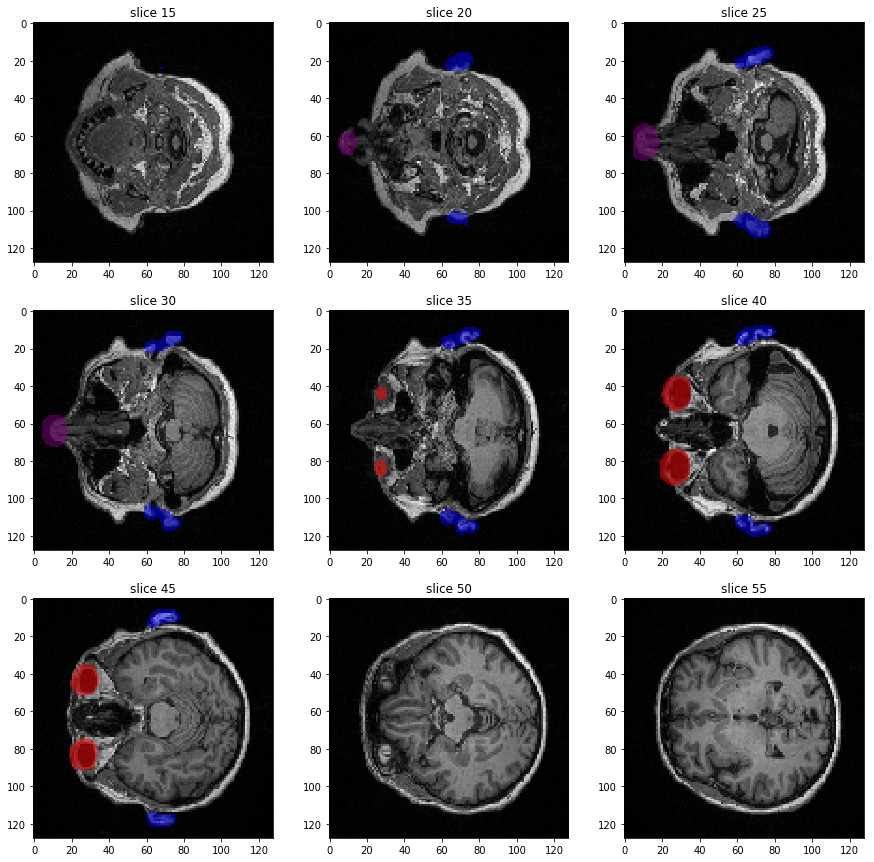

In [11]:
dicomtest_view(dicom_path)

In [21]:
#creating bound box of segmentation result. Ignoring execpt facial features(eyes, nose and ears) by using labeling, region prop 
#input: predicted label by model. ndarray(z,y,x,ch),
#output : bounding box coordinates list([z,y,x,Z, Y, X],[z,y,x,Z, Y, X],... as number of label clusters)
def bounding_box(results):

    boxes = list()
    for ch in range(2):  # except 0 label (blanck)
        if ch==0 : # eyes
            
            result = np.round(results[...,ch])
            lb=label(result,connectivity=1)
            
            region_list=list()
            for region in regionprops(lb):
                region_list.append(region.area)
                
            region_list_sort = sorted(region_list)
            max_region = np.where(region_list>=region_list_sort[-2]) # first maximum, second maximum region
            boxes.append(list(regionprops(lb)[max_region[0][0]].bbox))
            boxes.append(list(regionprops(lb)[max_region[0][1]].bbox))
        
        
        
        if ch==1 : # nose
           
            result = np.round(results[...,ch])
            lb=label(result,connectivity=1)

            region_list=list()
            for region in regionprops(lb):
                region_list.append(region.area)

            max_region=np.argmax(region_list)
            boxes.append(list(regionprops(lb)[max_region].bbox))
            
    
    return boxes

In [22]:
#input: 'xyz order' 3D array by nib.load, bound box coordinates, coordimnates of bounding box, processing type = blur or wipe(remove voxel)
#output: processed image array.
def box_blur(im_array,  box, Type, wth=1):
    
    # increase or decrease the size of the box by 'wth' times
    if wth != 1 :
        for c in range(3):
            mean_= (box[c]+box[c+3])/2
            box[c]=int(np.round(mean_-wth*(mean_-box[c])))
            box[c+3]=int(np.round(wth*(box[c+3]-mean_)+mean_))
            if box[c] < 0: box[c]=0
            if box[c+3] > im_array.shape[2-c]: box[c+3] = im_array.shape[2-c]   #order : im_array-> x,y,z / box-> z,y,x

 
    
    #voxel coordinates must be 'int'
    box_x1 = box[0]
    box_y1 = box[1]
    box_z1 = box[2]
    box_x2 = box[3]
    box_y2 = box[4]
    box_z2 = box[5]
    
    
    if Type.lower() =='blur':
        blurr_array = ndimage.median_filter(im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2],size=5) #size = filter size
        im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2] = blurr_array
    elif Type.lower() =='wipe':
        blurr_array=0
        im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2] = blurr_array
    else:
        raise print("type option error : select 'Blur' or 'Wipe'")
    
    return im_array


In [23]:
#input: 'xyz order' 3D array by nib.load, bound box coordinates, coordimnates of bounding box, processing type = blur or wipe(remove voxel)
# wth : You can increase or decrease the size of the box by 'wth' times.
# dep : Thickness to blur along surface.
#output: processed image array.
def surface_blur(im_array, edge_img, box, Type, wth ,dep):
    
    
    # increase or decrease the size of the box by 'wth' times
    if wth != 1 :
        for c in range(3):
            mean_= (box[c]+box[c+3])/2
            box[c]=int(np.round(mean_-wth*(mean_-box[c])))
            box[c+3]=int(np.round(wth*(box[c+3]-mean_)+mean_))
            if box[c] < 0: box[c]=0
            if box[c+3] > im_array.shape[2-c]: box[c+3] = im_array.shape[2-c]   #order : im_array-> x,y,z / box-> z,y,x

    
    
    #voxel coordinates must be 'int'
    box_x1 = box[0]
    box_y1 = box[1]
    box_z1 = box[2]
    box_x2 = box[3]
    box_y2 = box[4]
    box_z2 = box[5]
    
    mini_array = im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2]
            
    mini_edge = edge_img[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2]

    
    # dep  =eyes=2~3 ears 1~2
    if Type.lower() =='blur':
        where_true=np.where(mini_edge==True)
        
        for i in range(len(where_true[0])):
            x=where_true[0][i]
            y=where_true[1][i]
            z=where_true[2][i]
            mini_array[x-dep:x+dep,y-dep:y+dep,z-dep:z+dep]=ndimage.gaussian_filter(mini_array[x-dep:x+dep,y-dep:y+dep,z-dep:z+dep],sigma=7)
        
        
    elif Type.lower() =='wipe':
        where_true=np.where(mini_edge==True)

        for i in range(len(where_true[0])):
            x=where_true[0][i]
            y=where_true[1][i]
            z=where_true[2][i]
            mini_array[x-dep:x+dep,y-dep:y+dep,z-dep:z+dep]=0

    
    else:
        raise print("type option error : select 'Blur' or 'Wipe'")
    
    
    im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2] = mini_array 
    
    return im_array

In [24]:
def outer_contour_3D(image,zoom=1):
    #sort in standard size
    resize_factor = (128/image.shape[0], 128/image.shape[1], 128/image.shape[2])
    ima = ndimage.zoom(image,resize_factor,order=0, mode='constant', cval=0.0)
    
    # make binary cast
    thresh = threshold_triangle(ima)
    imageg=ndimage.median_filter(ima,size=3)
    binary_image = imageg > thresh
    for s in range(ima.shape[0]) :
        binary_image[s,:,:]=ndimage.morphology.binary_fill_holes(binary_image[s,:,:])
    for s in range(ima.shape[1]) :
        binary_image[:,s,:]=ndimage.morphology.binary_fill_holes(binary_image[:,s,:])
    for s in range(ima.shape[2]) :
        binary_image[:,:,s]=ndimage.morphology.binary_fill_holes(binary_image[:,:,s])
    
    # draw outer contour
    verts, faces, norm, val = marching_cubes_lewiner(binary_image,0)
    vint = np.round(verts).astype('int')
    contour = np.zeros_like(binary_image)
    for s in vint:
        contour[s[0],s[1],s[2]]=1
    
    # shrink contour image cuz of the gaussian_filter we used earlier.
    if zoom !=1 :
        c_shape = contour.shape
        zoom_ = ndimage.zoom(contour,zoom,order=0, mode='constant', cval=0.0)
        zoom_shape = zoom_.shape
        npad = ( (int(np.ceil((c_shape[0]-zoom_shape[0])/2)),int((c_shape[0]-zoom_shape[0])/2)), 
                (int(np.ceil((c_shape[1]-zoom_shape[1])/2)),int((c_shape[1]-zoom_shape[1])/2)),
                (int(np.ceil((c_shape[2]-zoom_shape[2])/2)),int((c_shape[2]-zoom_shape[2])/2)) )

        contour_3D = np.pad(zoom_,npad,'constant',constant_values = (0))
    elif zoom==1 : 
        contour_3D = contour
    
    #Revert to original size
    get_back = (image.shape[0]/128, image.shape[1]/128, image.shape[2]/128)
    contour_3D = ndimage.zoom(contour_3D,get_back,order=0, mode='constant', cval=0.0)
    
    return contour_3D

In [31]:
#where_do_you_want_to_blur? ex) where = (1,1,1) -> blur(eyes, nose, ears)
def Deidentification_image(where, Type, dicom_path, Model=model):
    '''
    where : list or tuple. Each position stands for eyes nose ears (eyes, nose, ears) 
            If the corresponding position is 1, de-identification process.
    
    Type : Image processing options. 'Wipe' , 'Blurr'
    
    dicom_path : Test set(labled or unlabled) data path. 
    model : Predictive model to be applied.

    '''
    # if typing another word, error raise. 
    options=['blur','wipe']
    if Type.lower() not in options: 
        raise print("type option error : select 'Blur' or 'Wipe'")
    

    slices = load_scan(dicom_path)
    array_img = get_pixels(slices)
    original_shape = array_img.shape
    thresh = threshold_triangle(array_img)
    
    #Header de identification
    header_deidentification(slices,check=False)
    
    # Make the superior coordinates the direction of increasing.
    def flip_axis(x, axis):
        x = np.asarray(x).swapaxes(axis, 0)
        x = x[::-1, ...]
        x = x.swapaxes(0, axis)
        return x

    X=slices[0][0x00200037].value[0:3]
    X=[float(i) for i in X]

    Y=slices[0][0x00200037].value[3:6]
    Y=[float(i) for i in Y]


    superior = [np.dot(X,[0,0,1]),  np.dot(Y,[0,0,1]),  np.dot(np.cross(X,Y),[0,0,1])]
    arg=np.argmax(np.abs(superior))

    if superior[arg] < 0 :
        image = flip_axis(array_img,arg)
    else : image = array_img



    #load prediction label 
    image=model.resize(image)
    image=image.reshape(1,128,128,128,1)
    results = model.model.predict(image)
    
    if superior[arg] < 0 :
        results=flip_axis(results,arg+1) # +1 : index 0 is batch size
        


    #preprocessing: Size recovery and transform onehot to labels number 
    if config["resizing"]==True :
        results = onehot2label(results)
        results = np.reshape(results,config["input_shape"][0:3]) # prediction results (batch size, dep, col ,row, ch) -> (dep, col ,row)
        results = model.resize(results,
                             img_dep=original_shape[0],
                             img_cols=original_shape[1],
                             img_rows=original_shape[2]) 
        results = to_categorical(results)[...,1:] # except 0 label (blanck)

    else:
        results=results[0,...,1:] # Only if batch size==1


    
    #search center by clustering
    boxes = bounding_box(results)        


    ## make outer contour for mini array.
    edge_img = outer_contour_3D(array_img,zoom=1)


    # 
    if where[0] == 1: # eyes

        box = boxes[0] # eye
        array_img = surface_blur(array_img, edge_img, box, Type, wth=1.2, dep=3)

        box = boxes[1] # eye
        array_img = surface_blur(array_img, edge_img, box, Type, wth=1.2, dep=3)               

    if where[1] == 1: # nose
        box = boxes[2]
        array_img = box_blur(array_img, box, Type='wipe', wth=1.33)

    if where[2] == 1: # ears
        '''
        In order not to see the outline of the ear due to external noise,
        fill the area of the ear with similar noise
        '''
        noise = np.random.rand(*original_shape)*thresh*0.8 
        array_img[results[...,2] == 1] = noise[results[...,2] == 1] 


    array_img=np.round(array_img)
    array_img=np.array(array_img,dtype='int16')
    ## processed 3D image array
    
    
    for i in range(len(slices)):
         
        slices[i].PixelData=array_img[i,:,:].tostring() # [i, :, : ] the reason is that function np.stack makes new axis as first axis
        
    
    if Type.lower() =='blur':    
        for i in range(len(slices)):
            instanceNum=pydicom.read_file(list_test_image[i]).InstanceNumber
            slices[instanceNum-1].save_as(os.path.join(config["test_save_path"],'Blurred_{}'.format(os.path.basename(list_test_image[i])))) #instance Number starts from 1. 
    elif Type.lower() =='wipe':    
        for i in range(len(slices)):
            instanceNum=pydicom.read_file(list_test_image[i]).InstanceNumber
            slices[instanceNum-1].save_as(os.path.join(config["test_save_path"],'Wipe_{}'.format(os.path.basename(list_test_image[i])))) #instance Number starts from 1. 
    



In [32]:
# config["test_save_path"]='D:/deface_project/dicom test'
Deidentification_image((1,1,1), 'wipe' , dicom_path,Model=model)

# EOF